In [1]:
import numpy as np
import pandas as pd
import time
import math
from math import sqrt
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

In [2]:
# ------------------------------------------------
# Choix des tailles de matrice (Q, K, V) et d
# ------------------------------------------------
seq_len, d_model = 2048, 64
x = np.random.randn(seq_len, d_model)

# ------------------------------------------------
# Choix des tailles de blocs à tester 
# ------------------------------------------------
min_size, max_size, step = 64, 512, 64
blocks = list(range(min_size, max_size + step, step))

In [3]:
import os

os.chdir('..')

In [4]:
import sys
sys.path.append('./cython_mat')
sys.path.append('./Quentin')

import mmat

## Calcul de l'attention (avec numpy)

In [5]:
# ------------------------
# Fonction d'attention (inchangée)
# ------------------------
import mmat


def run_attention_once_cython(x, block_size):
    return mmat.cython_attention(x, x, x, block_size)
    


# ------------------------
# Mesure de temps
# ------------------------
def measure_time(x, block_size):
    start = time.perf_counter()
    _ = run_attention_once_cython(x, block_size)
    return time.perf_counter() - start

## Grille exhaustive qui teste toutes les combinaisons

* Mesure initiale : pour chaque block_size, effectue initial_repeats mesures et stocke les temps.

* Choix du candidat : identifie le bloc dont la moyenne des temps initiaux est la plus faible.

* Échauffement : relance 5 mesures supplémentaires sur ce “best” pour estimer son intervalle de confiance (IC) à 95 % (Student-t).

* Itération : jusqu’à max_iter, répète :

* Recalcule la moyenne, l’écart-type et l’IC supérieur du “best”.

* Sélectionne tous les blocs dont la moyenne courante ≤ IC supérieur.

* Mesure chacun de ces candidats une fois de plus.

* Met à jour le “best” en choisissant, parmi les candidats, celui à la plus petite moyenne.

* Test de confiance : pour chaque autre bloc, effectue un test t de Welch contre le “best” et calcule la p-value unilatérale.

* Arrêt : dès que toutes les p-values sont < 0.05 (95 % de confiance que le “best” est plus rapide), on sort.

* Résultat : retourne la taille de bloc optimale, toutes les mesures accumulées, et le nombre total de tests effectués.

In [6]:
from benchmark import exhaustive_grid_until_confidence

result_grille = \
    exhaustive_grid_until_confidence(
        x, blocks,
        initial_repeats=4,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        verbose=True
    )


⚙️  Phase 0 : 20 free runs


Fin des free runs

🔍 Phase 1 : mesures initiales
Bloc 64   → médiane init : 0.00340 s
Bloc 128  → médiane init : 0.00478 s
Bloc 192  → médiane init : 0.00623 s
Bloc 256  → médiane init : 0.00801 s
Bloc 320  → médiane init : 0.01359 s
Bloc 384  → médiane init : 0.01917 s
Bloc 448  → médiane init : 0.04448 s
Bloc 512  → médiane init : 0.08314 s

🔁 Itération 1 : mesure de tous les blocs
 Bloc 64   → 0.00610 s (n=5)
 Bloc 128  → 0.00813 s (n=5)
 Bloc 192  → 0.06550 s (n=5)
 Bloc 256  → 0.01167 s (n=5)
 Bloc 320  → 0.01283 s (n=5)
 Bloc 384  → 0.07481 s (n=5)
 Bloc 448  → 0.01978 s (n=5)
 Bloc 512  → 0.08210 s (n=5)
 Meilleur moyen actuel : Bloc 64 (mean=0.00433)
  -> Bloc 64 vs Bloc 128: p=0.1081
  -> Bloc 64 vs Bloc 192: p=0.0778
  -> Bloc 64 vs Bloc 256: p=0.0007
  -> Bloc 64 vs Bloc 320: p=0.0440
  -> Bloc 64 vs Bloc 384: p=0.0268
  -> Bloc 64 vs Bloc 448: p=0.0164
  -> Bloc 64 vs Bloc 512: p=0.0018

🔁 Itération 2 : mesure de tous les blocs
 Bloc 64   → 0.00571 s (n=6)
 Bloc 128  → 0.00

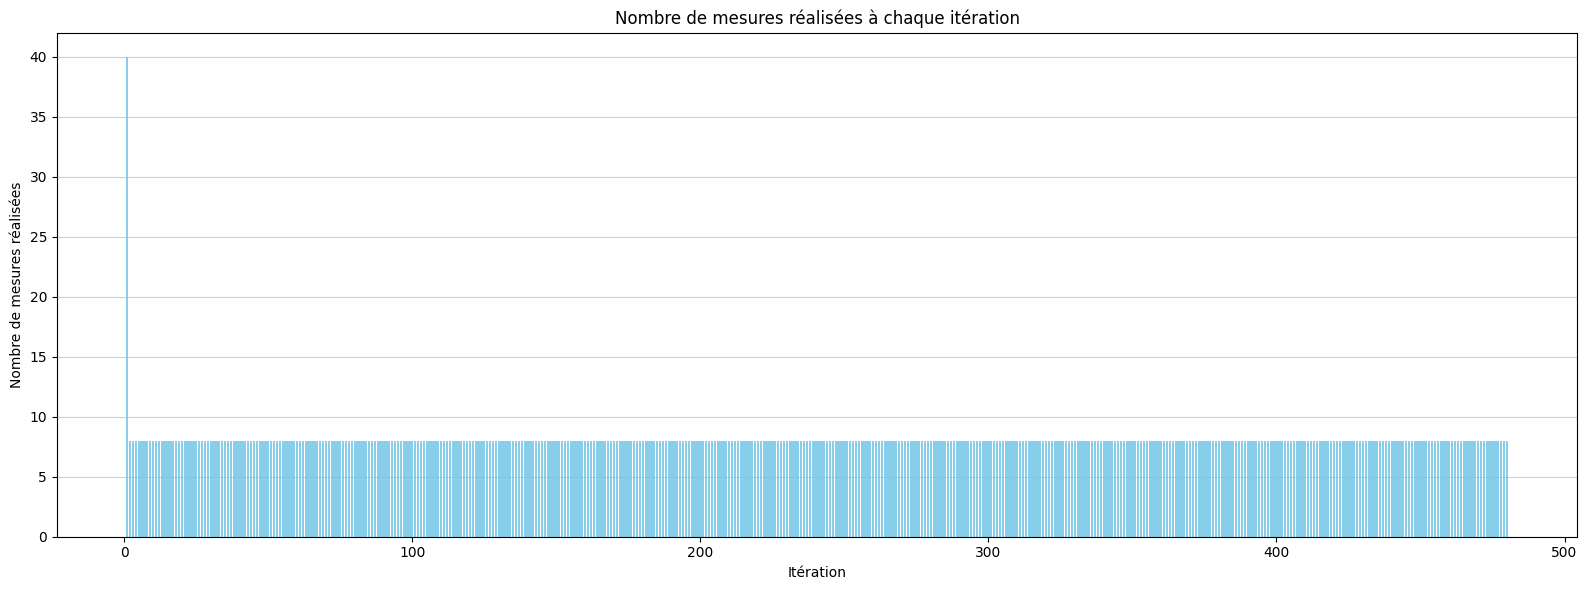

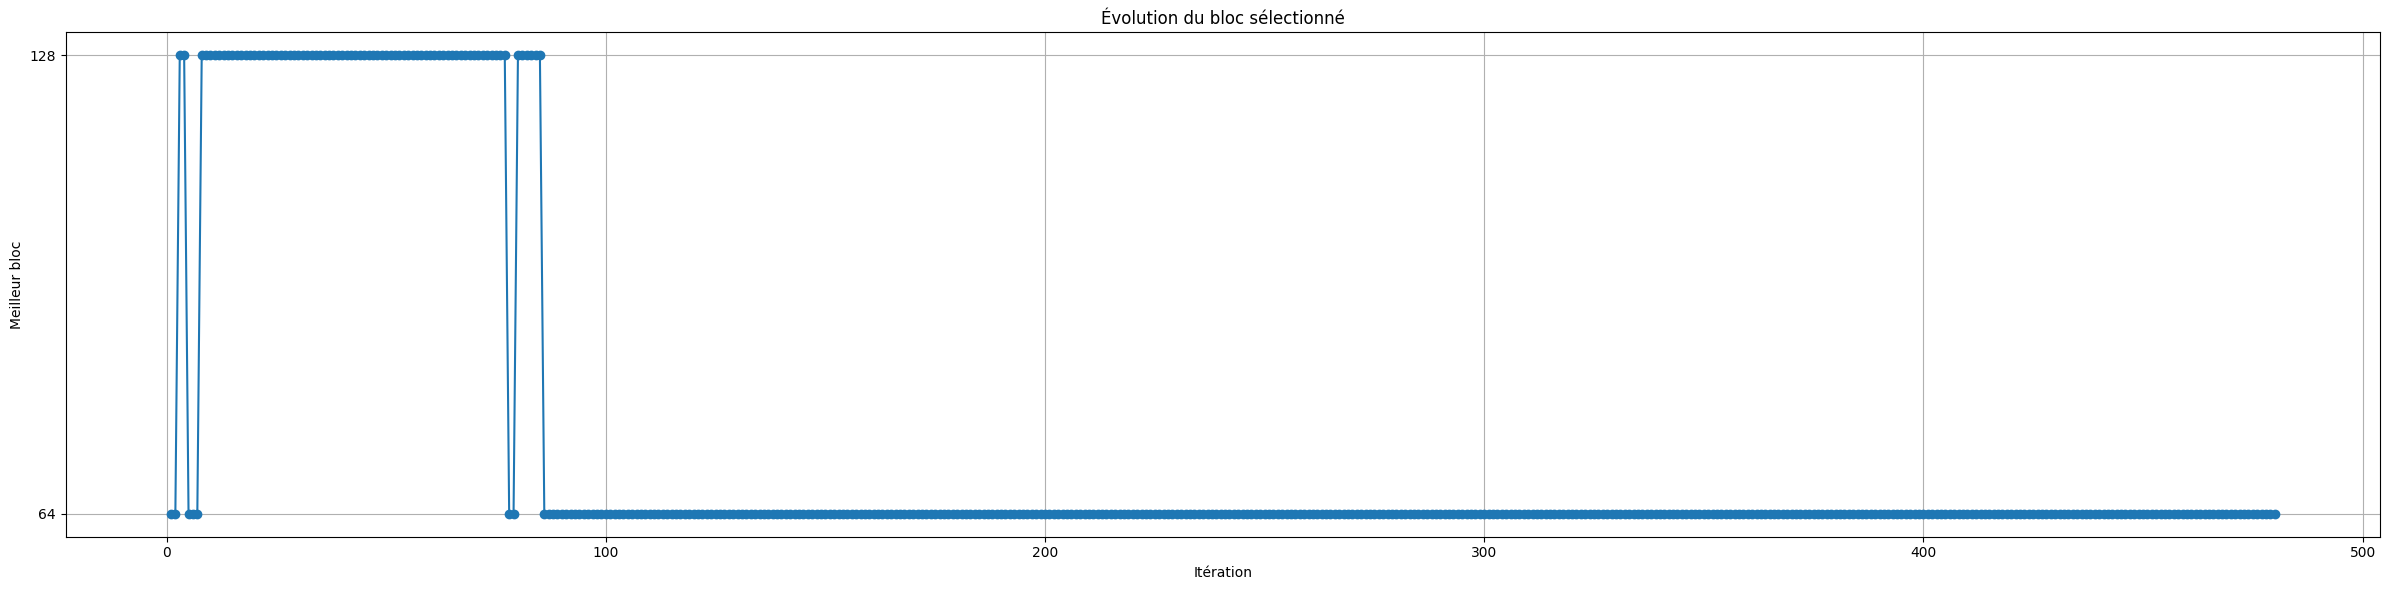

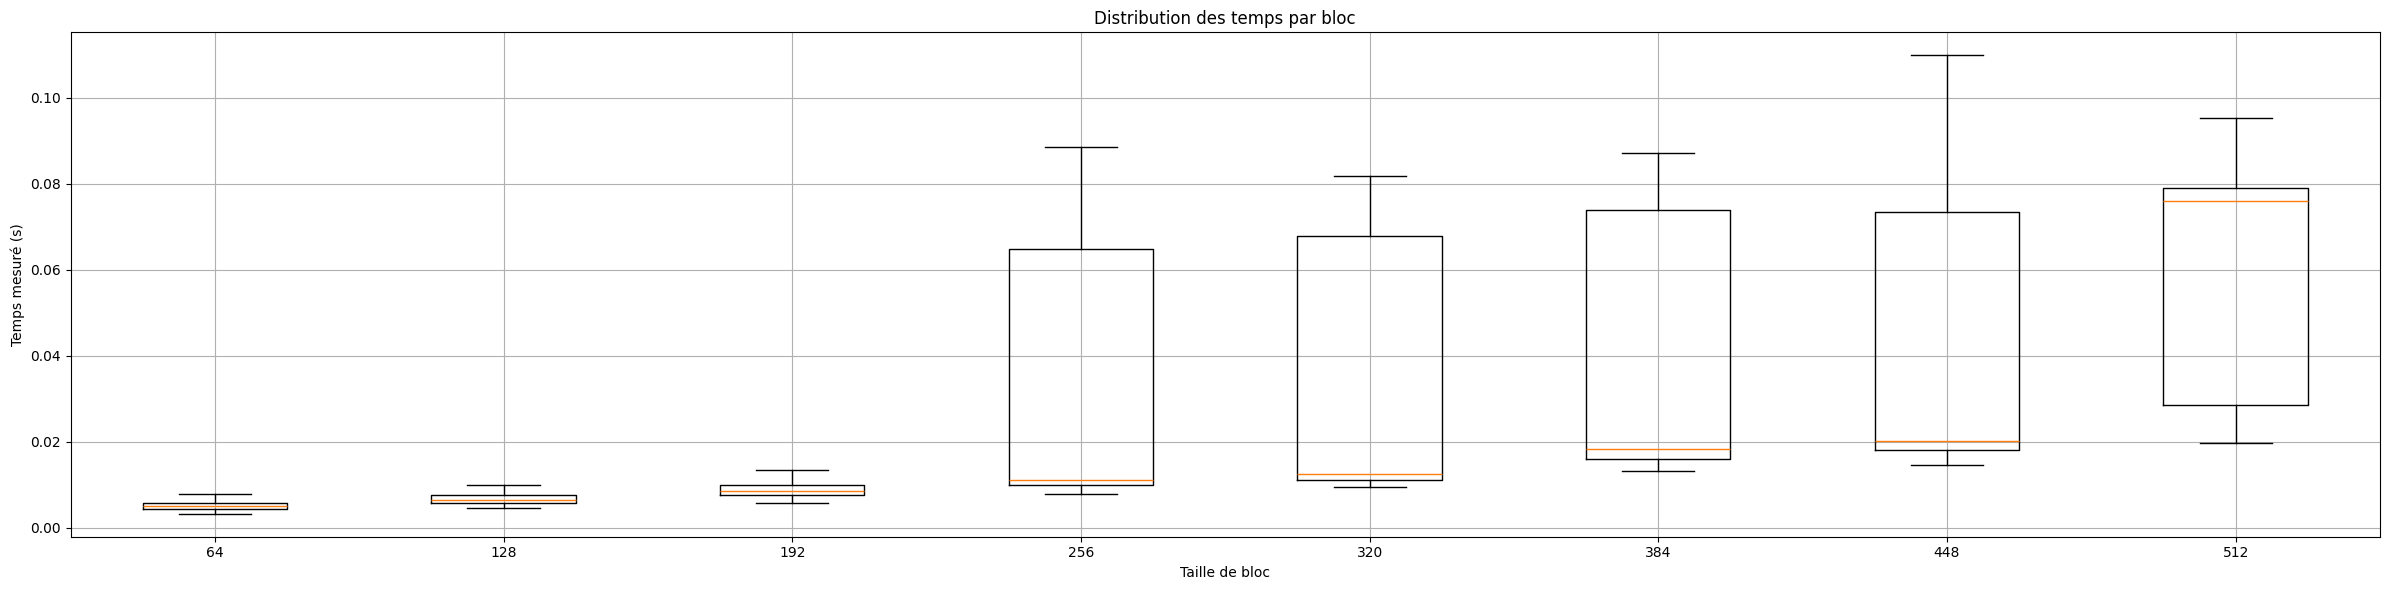

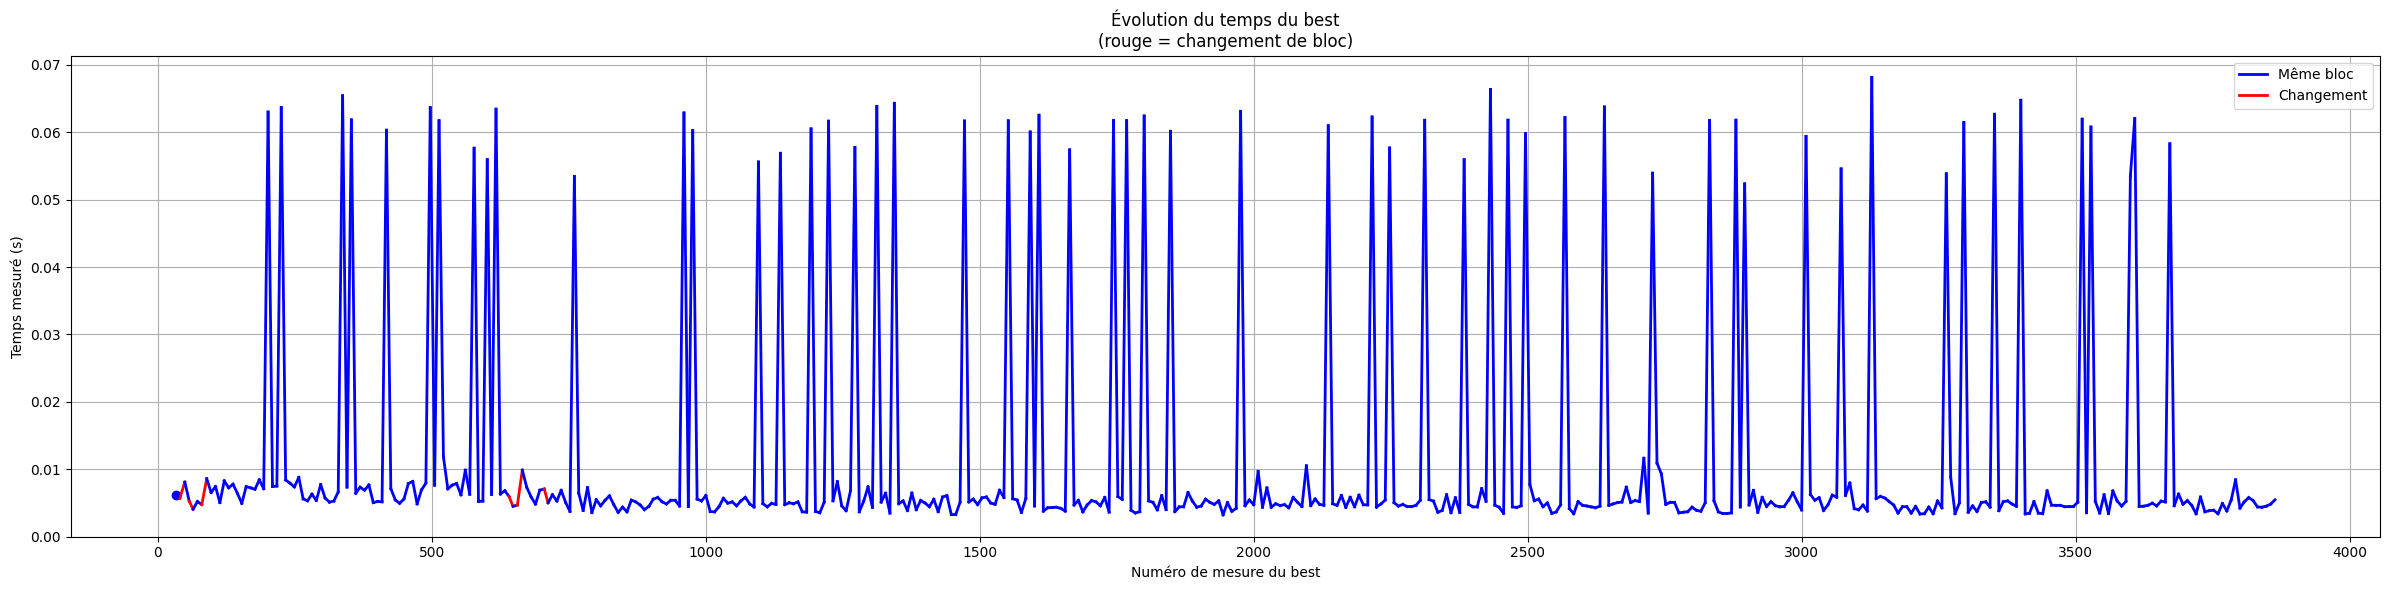

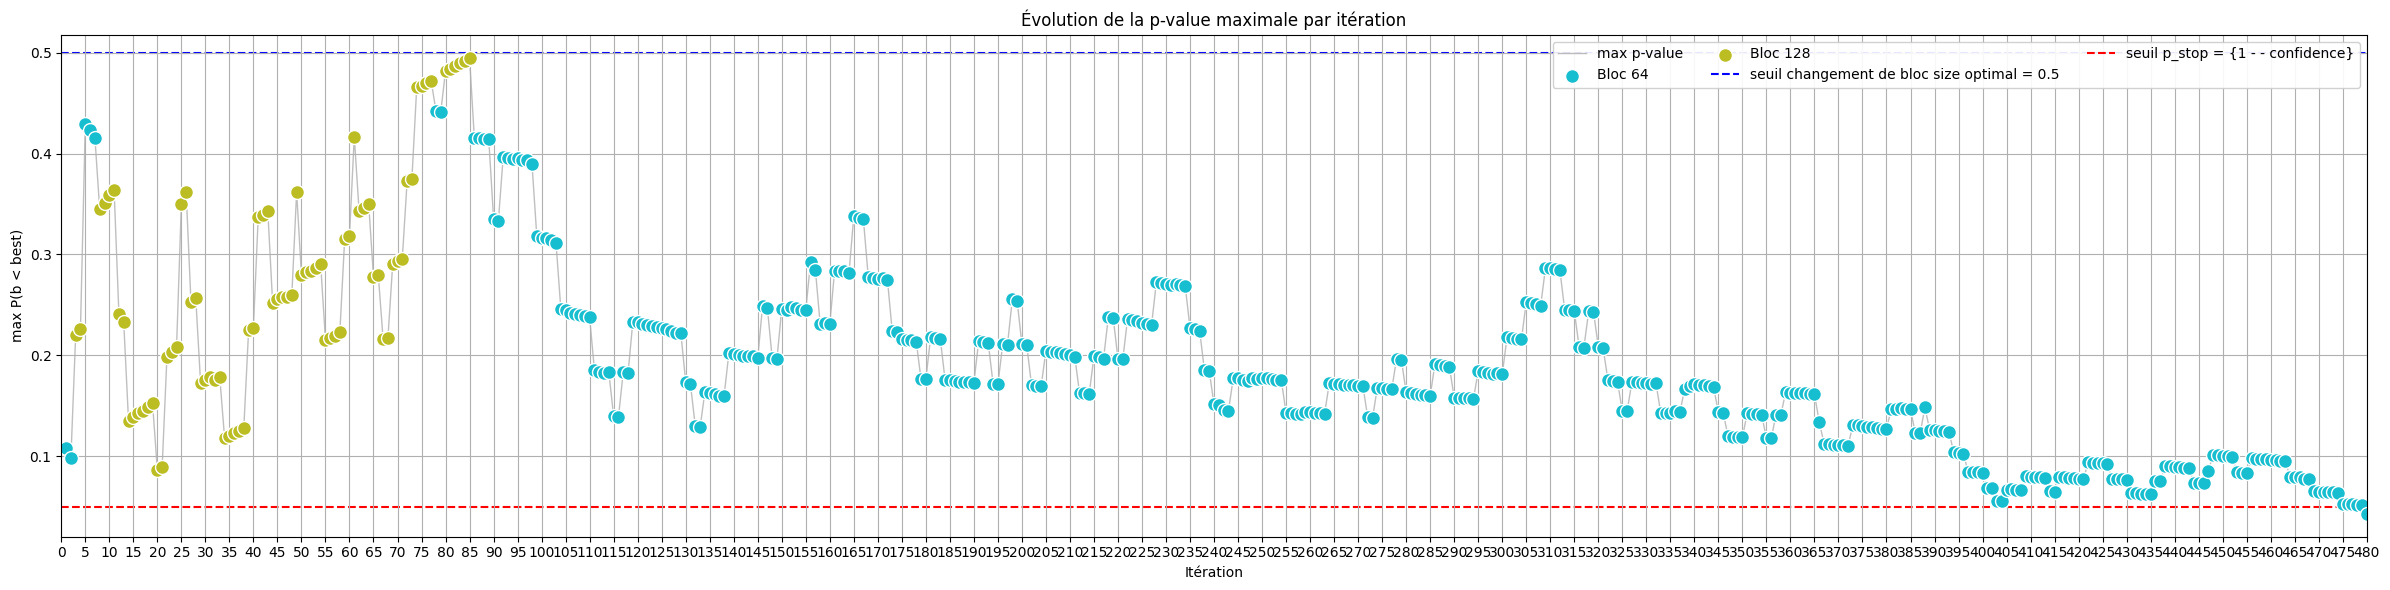

In [7]:
from graphique import plot_all_graphs

plot_dict_grille = {
    'best_track': result_grille['best_track'],
    'best_measurements': result_grille['best_measurements'],
    'results': result_grille['results'],
    'measure_per_iter': result_grille['measure_per_iter'],
    'p_history': result_grille['p_history'],
}

plot_all_graphs(
    blocks,
    **plot_dict_grille,
    p_switch=0.5,
    figsize=(24, 6),
    step=step,
)

## Meilleur Benchmark

In [8]:
from benchmark import smart_benchmark_probabilistic


result_adaptatif_benchmark = \
    smart_benchmark_probabilistic(
        x, blocks,
        initial_repeats=4,
        free_runs=20,
        confidence=0.95,
        max_iter=1000,
        extra_repeats_best=0,
        verbose=True
    )

⚙️  Phase 0 : 20 free runs


Fin des free runs

🔍 Phase 1 : mesures initiales
Bloc 64   → 0.00371 s (n=4)
Bloc 128  → 0.02065 s (n=4)
Bloc 192  → 0.02102 s (n=4)
Bloc 256  → 0.01089 s (n=4)
Bloc 320  → 0.01309 s (n=4)
Bloc 384  → 0.01081 s (n=4)
Bloc 448  → 0.03840 s (n=4)
Bloc 512  → 0.03122 s (n=4)

Best initial : 64

🔁 Itération 1: best = 64
  P(128 plus rapide que 64) = 0.159
  P(192 plus rapide que 64) = 0.159
  P(256 plus rapide que 64) = 0.041
  P(320 plus rapide que 64) = 0.046
  P(384 plus rapide que 64) = 0.000
  P(448 plus rapide que 64) = 0.046
  P(512 plus rapide que 64) = 0.079
Mesures supplémentaires : [64, 128, 192, 512]
  Bloc 64   → 0.00353 s (n=5)
  Bloc 128  → 0.00548 s (n=5)
  Bloc 192  → 0.06332 s (n=5)
  Bloc 512  → 0.02066 s (n=5)

🔁 Itération 2: best = 64
  P(128 plus rapide que 64) = 0.144
  P(192 plus rapide que 64) = 0.070
  P(256 plus rapide que 64) = 0.041
  P(320 plus rapide que 64) = 0.046
  P(384 plus rapide que 64) = 0.000
  P(448 plus rapide que 64) = 0.046
  P(512 plus rapide qu

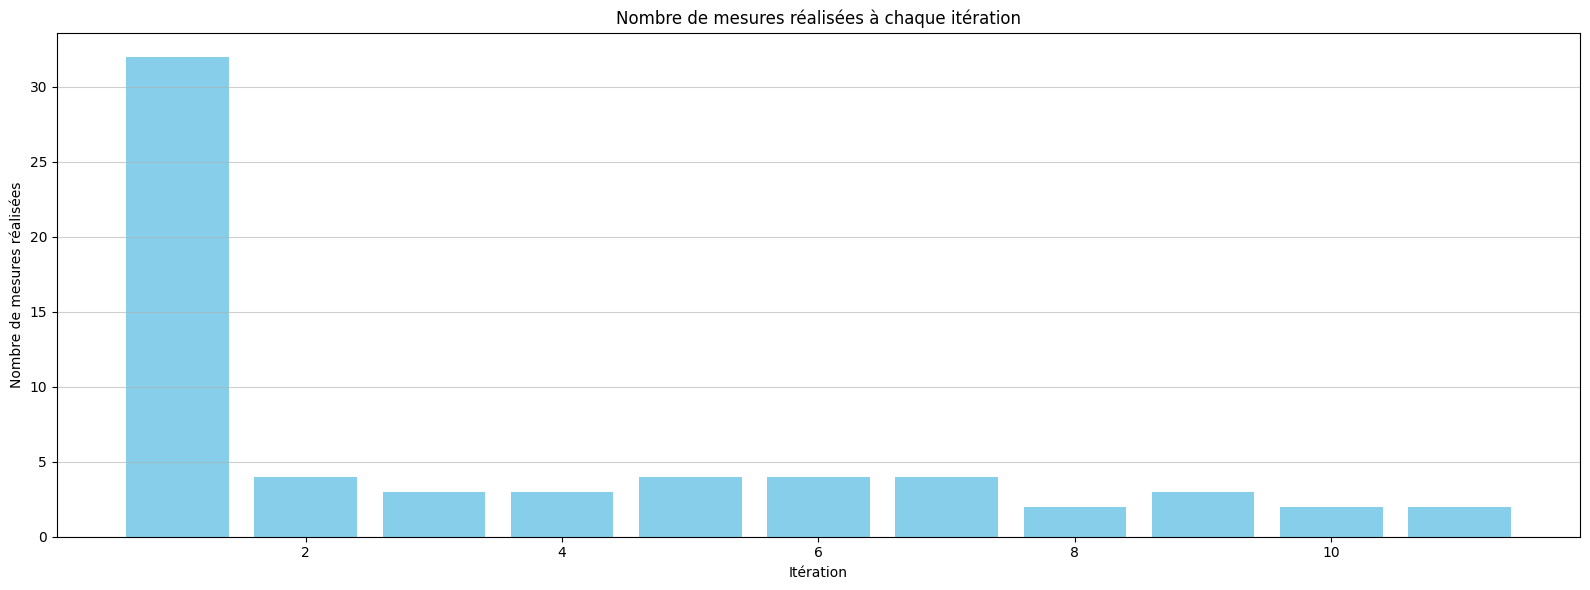

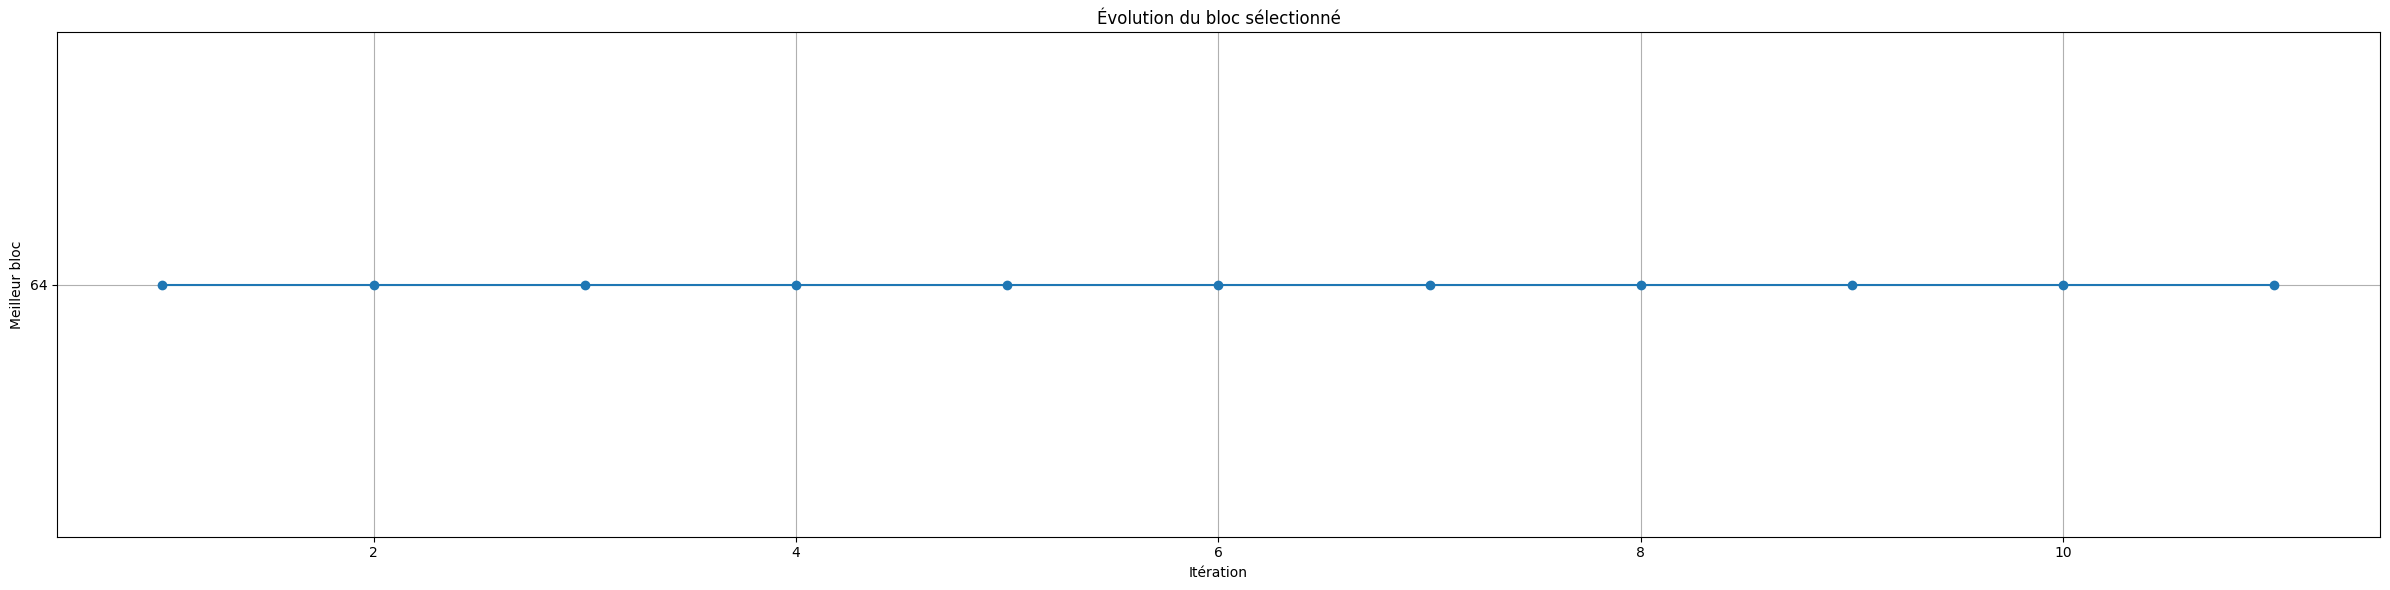

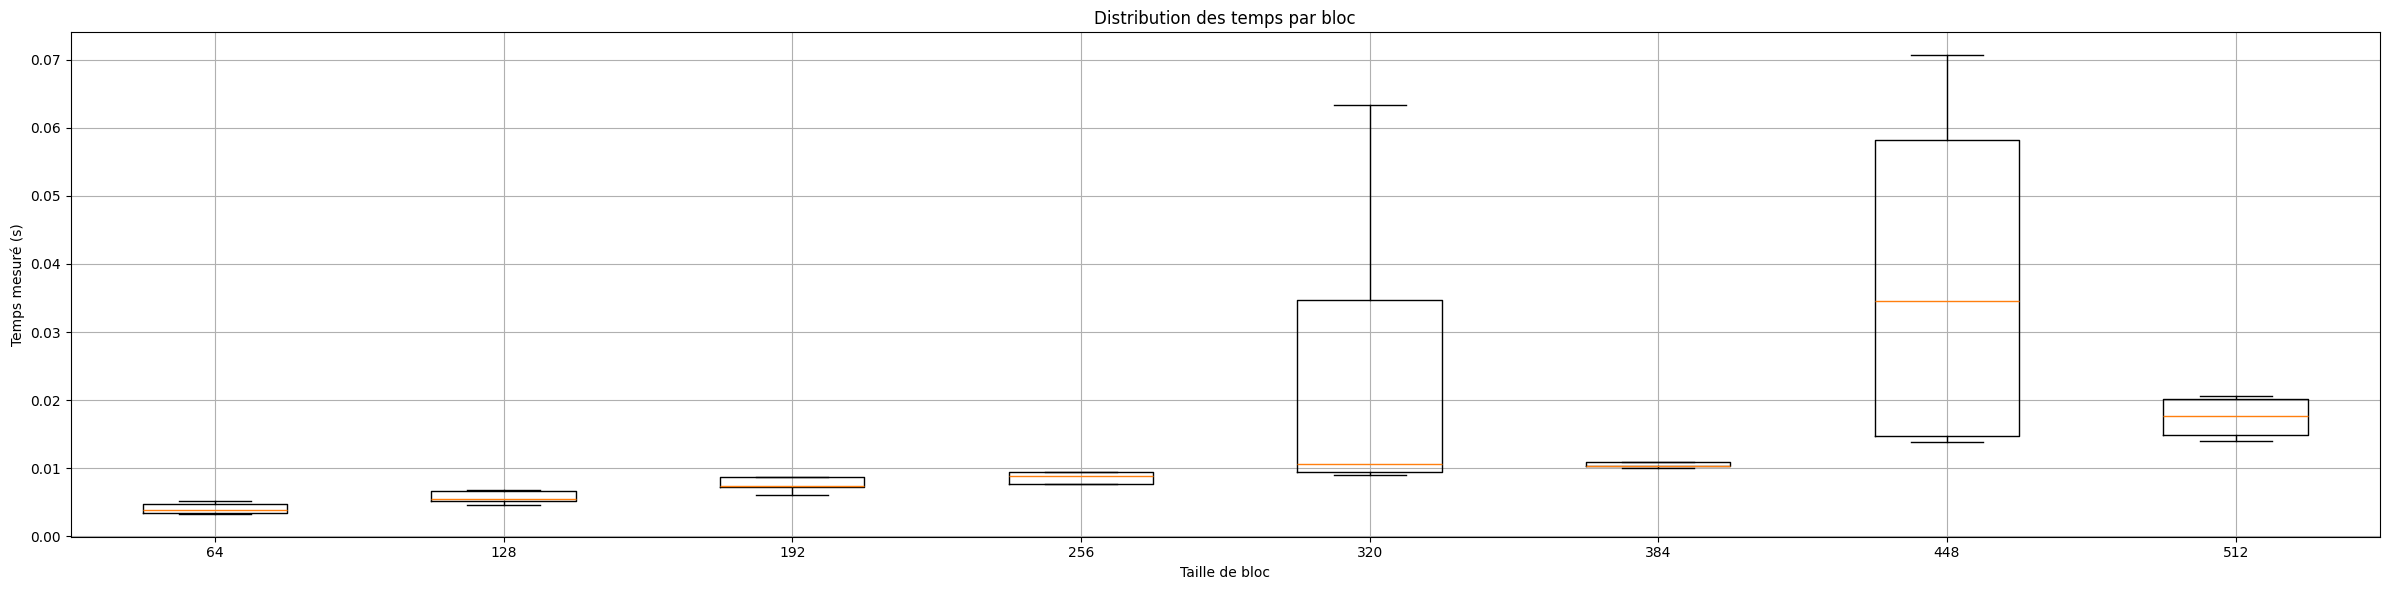

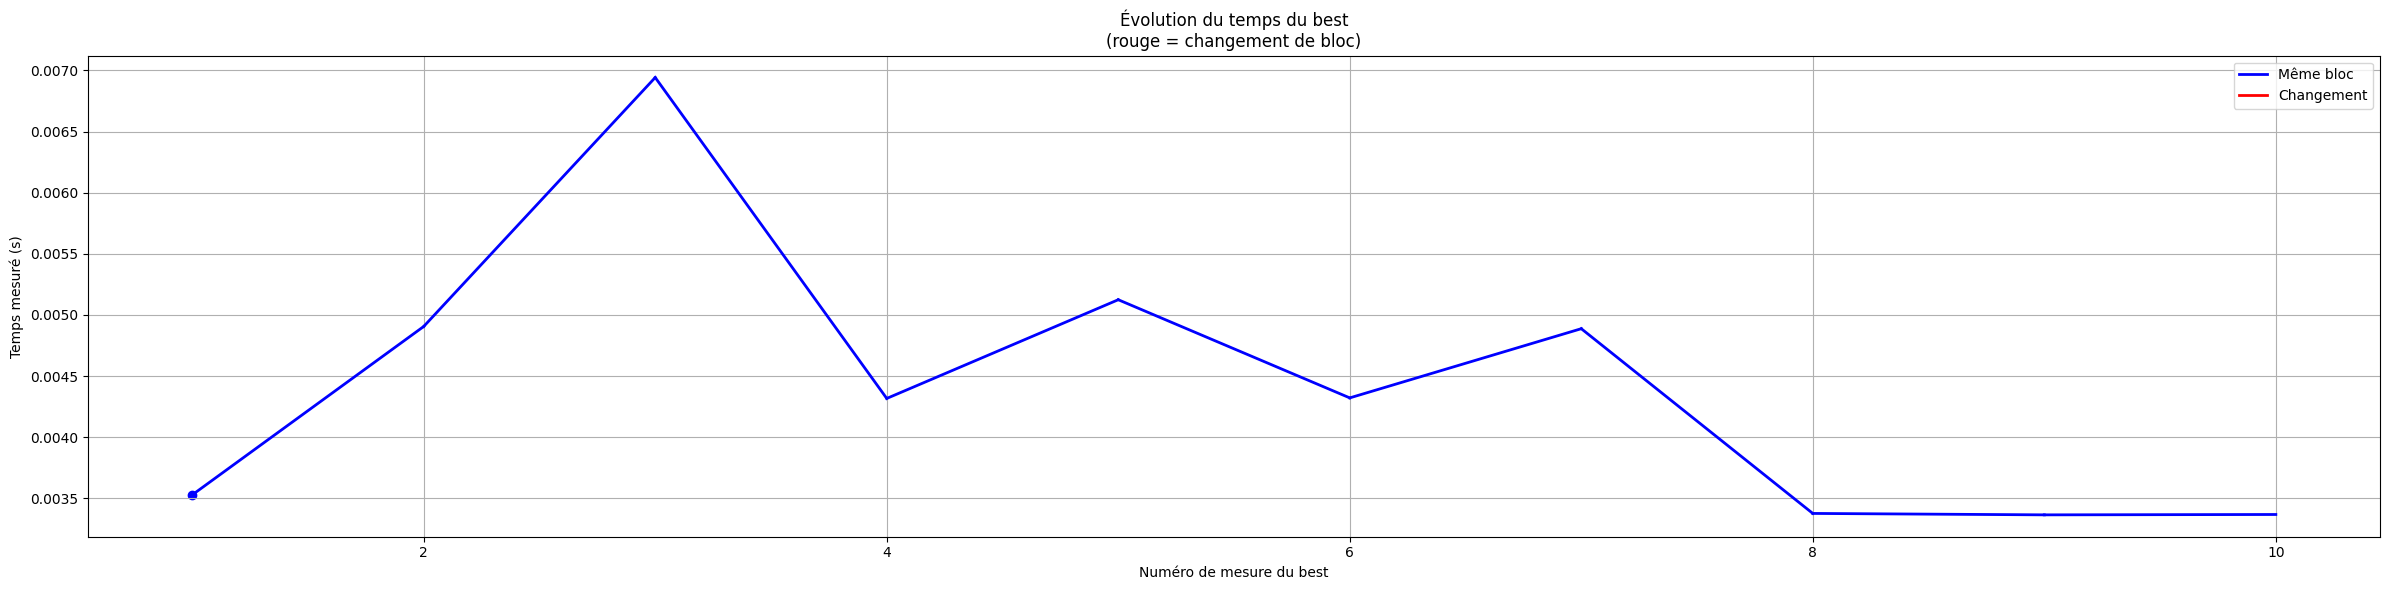

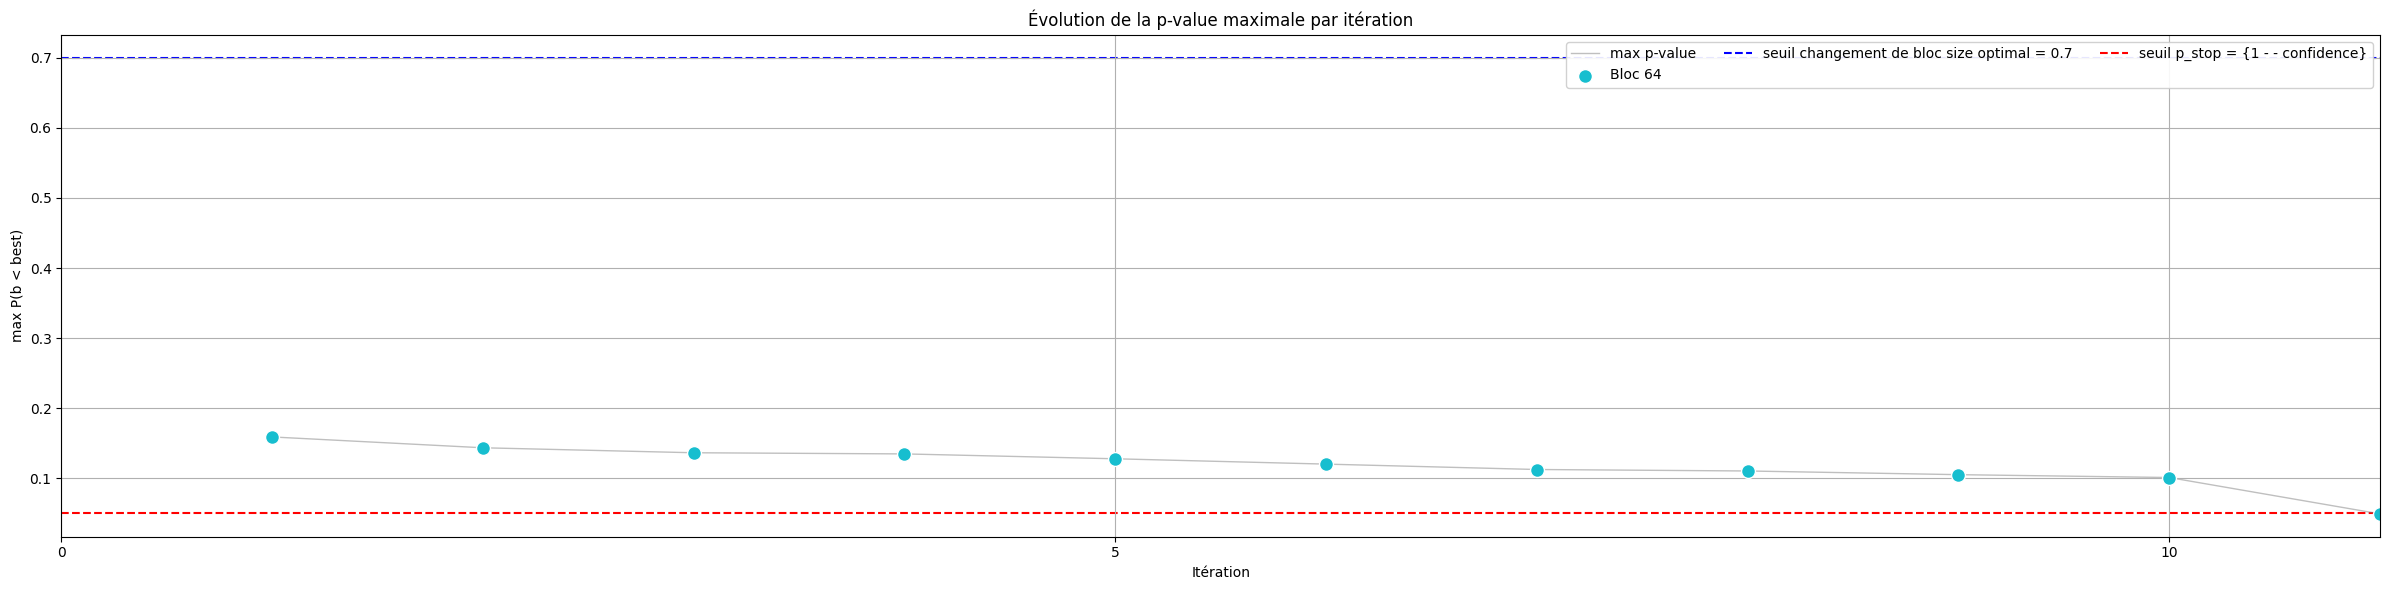

In [9]:
from graphique import plot_all_graphs

plot_dict_adaptatif_benchmark = {
    'best_track':           result_adaptatif_benchmark['best_track'],
    'best_measurements':    result_adaptatif_benchmark['best_measurements'],
    'results':              result_adaptatif_benchmark['results'],
    'measure_per_iter':     result_adaptatif_benchmark['measure_per_iter'],
    'p_history':            result_adaptatif_benchmark['p_history'],
}

plot_all_graphs(
    blocks,
    **plot_dict_adaptatif_benchmark,
    step=step,
    figsize=(24, 6),
    p_switch=0.7
)

## On compare l'evolution des p_value pour les 2 méthodes benchamrks (grille et adaptatif)

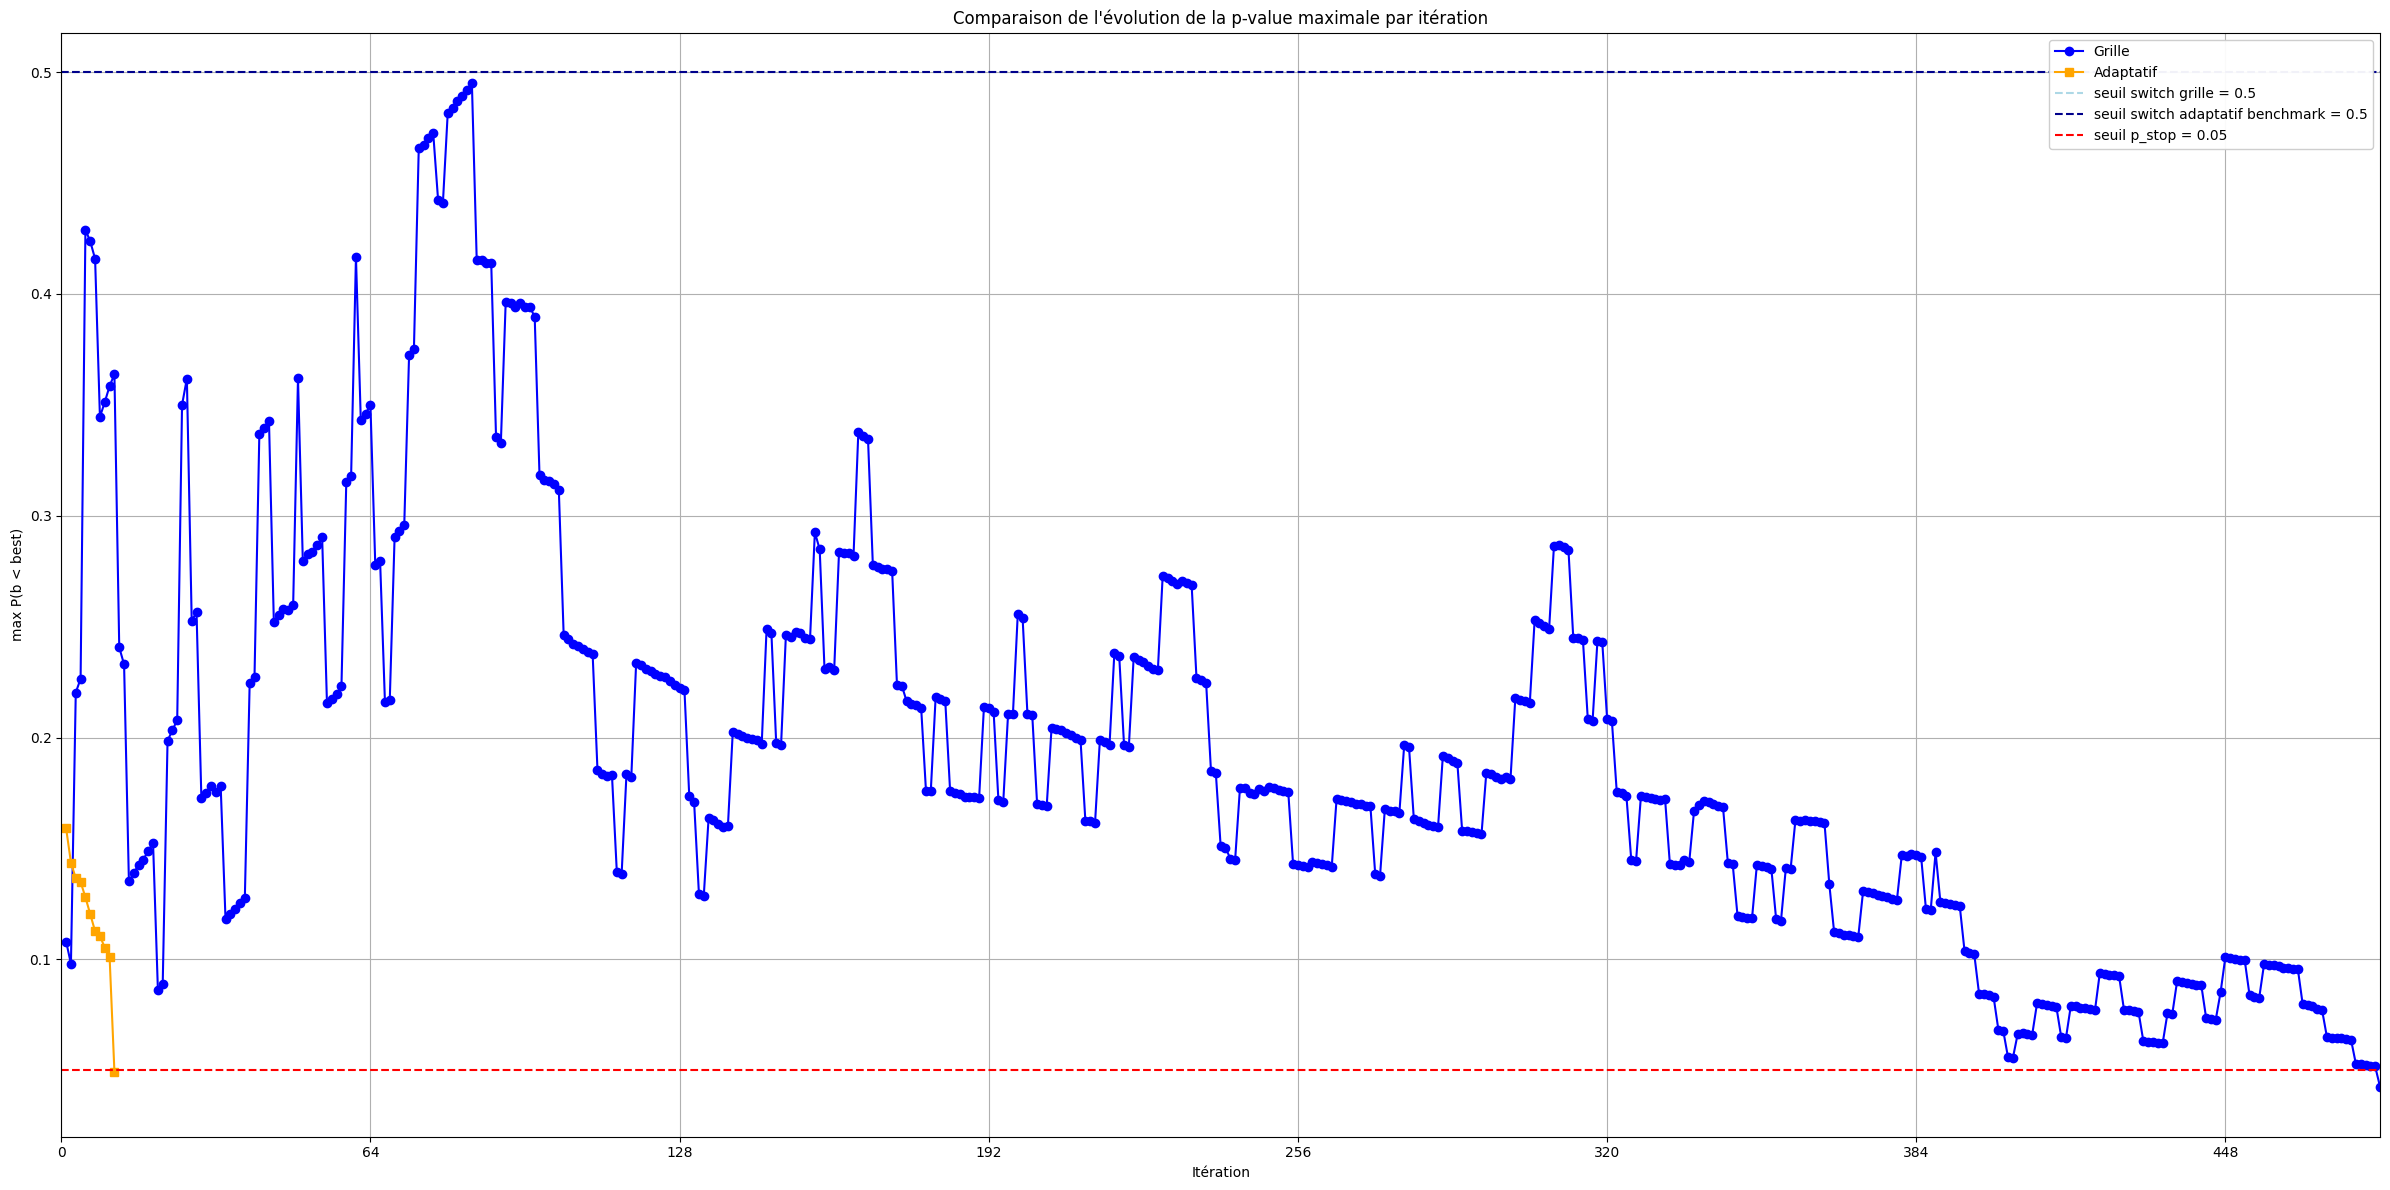

In [10]:
from graphique import compare_pvalue_evolution

compare_pvalue_evolution(
    result_grille['best_track'], result_grille['p_history'], 'Grille',
    result_adaptatif_benchmark['best_track'], result_adaptatif_benchmark['p_history'], 'Adaptatif',
    step=step,
    figsize=(24, 12)
)




# On test 20 fois le méthode grille VS le benchmark adaptatif pour comparer les 2 méthodes entre elles

In [11]:
N_REPEATS = 20

iterations_grille = []
mesures_grille = []
best_bloc_grille = []

iteration_smartB = []
mesures_smartB = []
best_bloc_smartB = []

for i in range(N_REPEATS):  
    # On change de matrice à chaque iteration
    x = np.random.randn(seq_len, d_model)

    # Grille exhaustive
    result_grille = exhaustive_grid_until_confidence(
        x, blocks, initial_repeats=2, free_runs=2, confidence=0.95, max_iter=1_000, verbose=False
    )
    n_iterations_grille = len(result_grille['best_track'])
    n_mesures_grille = result_grille['measure_per_iter'][-1] if result_grille['measure_per_iter'] else 0
    best_block_g = result_grille['best']  # <---- récupère le best trouvé

    iterations_grille.append(n_iterations_grille)
    mesures_grille.append(n_mesures_grille)
    best_bloc_grille.append(best_block_g)

    # Smart benchmark
    result_smartB = smart_benchmark_probabilistic(
        x, blocks, initial_repeats=2, free_runs=2, confidence=0.95, max_iter=1_000, p_switch=0.70, verbose=False
    )
    n_iterations_smart_bench = len(result_smartB['best_track'])
    n_mesures_smart_bench = result_smartB['measure_per_iter'][-1] if result_smartB['measure_per_iter'] else 0
    best_block_s = result_smartB['best']  # <---- récupère le best trouvé

    iteration_smartB.append(n_iterations_smart_bench)
    mesures_smartB.append(n_mesures_smart_bench)
    best_bloc_smartB.append(best_block_s)

    print(f"Test {i+1} terminé pour les 2 benchmark (grille et adaptatif)")

# --- Construction du tableau final ---
df = pd.DataFrame({
    "best_bloc_grille": best_bloc_grille,
    "best_bloc_adaptatif": best_bloc_smartB
})
df["meme_resultat"] = df["best_bloc_grille"] == df["best_bloc_adaptatif"]

print(df)


Test 1 terminé pour les 2 benchmark (grille et adaptatif)
Test 2 terminé pour les 2 benchmark (grille et adaptatif)
Test 3 terminé pour les 2 benchmark (grille et adaptatif)
Test 4 terminé pour les 2 benchmark (grille et adaptatif)
Test 5 terminé pour les 2 benchmark (grille et adaptatif)
Test 6 terminé pour les 2 benchmark (grille et adaptatif)
Test 7 terminé pour les 2 benchmark (grille et adaptatif)
Test 8 terminé pour les 2 benchmark (grille et adaptatif)
Test 9 terminé pour les 2 benchmark (grille et adaptatif)
Test 10 terminé pour les 2 benchmark (grille et adaptatif)
Test 11 terminé pour les 2 benchmark (grille et adaptatif)
Test 12 terminé pour les 2 benchmark (grille et adaptatif)
Test 13 terminé pour les 2 benchmark (grille et adaptatif)
Test 14 terminé pour les 2 benchmark (grille et adaptatif)
Test 15 terminé pour les 2 benchmark (grille et adaptatif)
Test 16 terminé pour les 2 benchmark (grille et adaptatif)
Test 17 terminé pour les 2 benchmark (grille et adaptatif)
Test 1

=== Résumé sur 20 lancements ===
Grille exhaustive   : 40.0 itérations, 336.0 mesures en moyenne
Benchmark adaptatif : 54.7 itérations, 238.3 mesures en moyenne


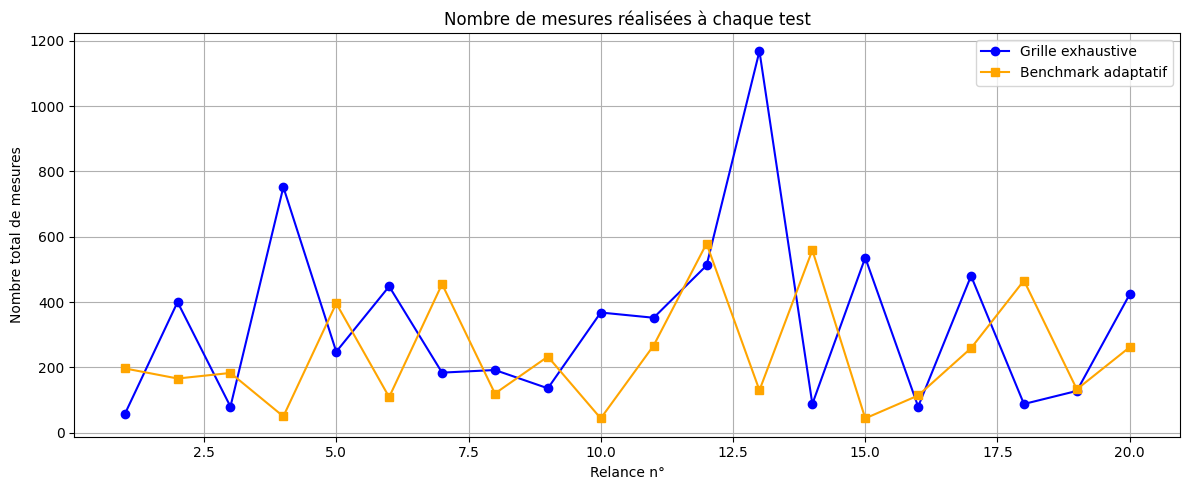

In [12]:
# Affichage des moyennes
print("=== Résumé sur", N_REPEATS, "lancements ===")
print(f"Grille exhaustive   : {np.mean(iterations_grille):.1f} itérations, {np.mean(mesures_grille):.1f} mesures en moyenne")
print(f"Benchmark adaptatif : {np.mean(iteration_smartB):.1f} itérations, {np.mean(mesures_smartB):.1f} mesures en moyenne")

# Graphique des mesures réalisées à chaque test
plt.figure(figsize=(12, 5))
plt.plot(range(1, N_REPEATS+1), mesures_grille, marker='o', color='blue', label="Grille exhaustive")
plt.plot(range(1, N_REPEATS+1), mesures_smartB, marker='s', color='orange', label="Benchmark adaptatif")
plt.xlabel("Relance n°")
plt.ylabel("Nombre total de mesures")
plt.title("Nombre de mesures réalisées à chaque test")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()